# <center> XGBoost incl. Cross-validation and Parametertuning </center>
***
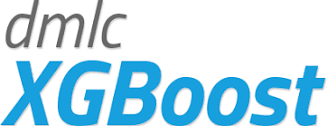


# 1. Load packages and data

In [26]:
# load packages
import time
import matplotlib.pyplot as plt
import numpy as np 
import pandas as pd 
from sklearn.ensemble import GradientBoostingRegressor 
from sklearn.model_selection import train_test_split, GridSearchCV 
import xgboost

# list files in the input directory
from subprocess import check_output
print(check_output(["ls", "../input"]).decode("utf8"))

data_p.csv



In [52]:
#load data
data = pd.read_csv("../input/data_p.csv")
#data.head()
#data.shape
#data.info()

#split into features X and label y
X = data.drop("preparationtime", axis=1)
y = data["preparationtime"]

#create dummy variables 
X = pd.get_dummies(X, drop_first = True)

#divide data into train/test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size =0.2, random_state = 6215)
print(X_train.columns.values)
print("number of rows/cols of X_train:", X_train.shape)
print("number of rows/cols of X_test:", X_test.shape)
print("number of rows/cols of y_train:", y_train.shape)
print("number of rows/cols of y_test:", y_test.shape)

['Unnamed: 0' 'sales' 'quantity' 'discount' 'profit' 'orderdate_day'
 'orderdate_month' 'orderdate_year' 'shipdate_day' 'shipdate_month'
 'shipdate_year' 'shipmode_Same Day' 'shipmode_Second Class'
 'shipmode_Standard Class' 'segment_Corporate' 'segment_Home Office'
 'region_East' 'region_South' 'region_West' 'state_Arizona'
 'state_Arkansas' 'state_California' 'state_Colorado' 'state_Connecticut'
 'state_Delaware' 'state_District of Columbia' 'state_Florida'
 'state_Georgia' 'state_Idaho' 'state_Illinois' 'state_Indiana'
 'state_Iowa' 'state_Kansas' 'state_Kentucky' 'state_Louisiana'
 'state_Maine' 'state_Maryland' 'state_Massachusetts' 'state_Michigan'
 'state_Minnesota' 'state_Mississippi' 'state_Missouri' 'state_Montana'
 'state_Nebraska' 'state_Nevada' 'state_New Hampshire' 'state_New Jersey'
 'state_New Mexico' 'state_New York' 'state_North Carolina'
 'state_North Dakota' 'state_Ohio' 'state_Oklahoma' 'state_Oregon'
 'state_Pennsylvania' 'state_Rhode Island' 'state_South Carolina

# 2. First simple model
**What?** very simple first model with default settings/parameter etc. <br>
**Why?** benchmark for following complex models

In [32]:
# Start measuring time 
start = time.time()

# Instantiate XGBRegressor
xgb = xgboost.XGBRegressor(random_state=123)
    #random_state: random number seed

# Fit classifier to training data
xgb.fit(X_train, y_train)

print("--- XGBRegressor took %s seconds ---" % (time.time() - start))

# Predict labels of test data
pred = xgb.predict(X_test)

--- XGBRegressor took 1.8608746528625488 seconds ---


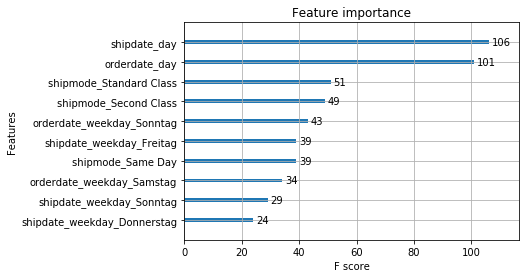

In [43]:
#plot feature importance
xgboost.plot_importance(booster = xgb, 
                        max_num_features = 10, 
                        importance_type = "weight")
    #importance_type "weight": number of times a feature appears in a tree 

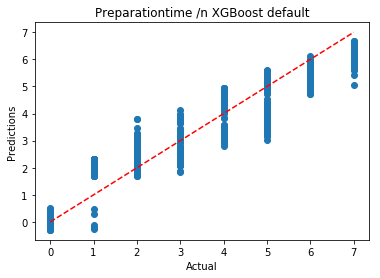

In [7]:
#plot predicted vs. actual preparationtime
line = np.linspace(0,7,7)

plt.scatter(y_test, pred)
plt.title("Preparationtime /n XGBoost default")
plt.xlabel("Actual")
plt.ylabel("Predictions")
plt.plot(line, line, 'r--')

In [8]:
# Compute rmse
rmse = xgb.score(X_test, y_test)
print("rmse: %f" % (rmse))

rmse: 0.869306



# 3. Cross-validation and parametertuning
* Cross-validation: <br>
**What?** Generate a number of non-overlapping train/test splits on training data <br>
**Why?** Test how well the trained model will generalize to new data 
<img "src=https://cdn-images-1.medium.com/max/800/1*J2B_bcbd1-s1kpWOu_FZrg.png" alt="Drawing" style="width: 450px;"/> 

* Parametertuning: <br>
**What?** Use GridSearch or RandomSearch to tune the parameter of your algorithm <br>
**Why?** Tweak your model to the very best ;-) 
<img "src=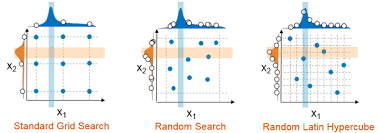" alt="Drawing" style="width: 450px;"/>

In [9]:
# Create parameter distribution for GridSearch
param = {'max_depth': [4, 6, 8], #swallow vs. deep trees
         'colsample_bytree': [0.4, 0.6, 0.8] #fraction of features to choose from at every split in a given tree
}

# Perform grid search: grid_mse
start = time.time()
gridsearch = GridSearchCV(estimator = xgb, 
                          param_grid = param, #Parameter to use
                          scoring = "neg_mean_squared_error",
                          cv = 4) #number of cross-validation rounds
                            

# Fit classifier to training data
gridsearch.fit(X_train, y_train)

print("--- XGBRegressor with RandomizedSearchCV took %s seconds ---" % (time.time() - start))

# Predict labels of test data
pred_gridsearch = gridsearch.predict(X_test)

--- XGBRegressor with RandomizedSearchCV took 55.59223413467407 seconds ---


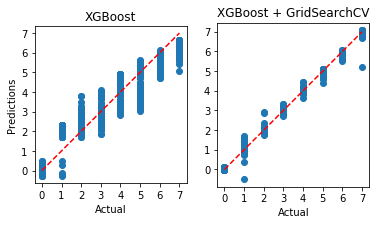

In [44]:
#plot predicted vs. actual preparationtime
xticks = [0,1,2,3,4,5,6,7]
plt.subplot(1,2,1, aspect = "equal")
plt.scatter(y_test, pred)
plt.title("XGBoost")
plt.xlabel("Actual")
plt.ylabel("Predictions")
plt.yticks(xticks)
plt.xticks(xticks)
plt.plot(line, line, 'r--')

plt.subplot(1,2,2, aspect = "equal")
plt.scatter(y_test, pred_gridsearch)
plt.title("XGBoost + GridSearchCV")
plt.xlabel("Actual")
plt.yticks(xticks)
plt.xticks(xticks)
plt.plot(line, line, 'r--')

plt.show()

In [45]:
# Print the best parameters and lowest RMSE
print("Best parameters found: ", gridsearch.best_params_)
print("Best estimator:", gridsearch.best_estimator_)
print("RMSE: %f" % (np.abs(gridsearch.score(X_test, y_test))))

Best parameters found:  {'colsample_bytree': 0.8, 'max_depth': 8}
Best estimator: XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.8, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=8, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='reg:linear', random_state=123,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)
RMSE: 0.008865
